In [2]:
import numpy as np
import torch
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from dataclasses import dataclass
import random
from enviroments import env_red_toy, env_red_toy1, env_hubs4,env_red_toy3,env_hubs3
import pickle
from algorithms.Action_Gen import Action_generation
from algorithms.RDQL import action_space_generation, ini_action_list
from algorithms.DQL import DQL_algorithm
from algorithms.QL import QL_algorithm
import time
from algorithms.models import QfunNN

NUMERO_DE_NUCLEOS = 64

torch.set_num_threads(NUMERO_DE_NUCLEOS)


In [3]:
name_exp = "Exp23"
Red_name = "env_red_toy3"
Demand_Model = "Exp" #Puede ser EXP/MNL
Qfun_model = "NN" #Puede ser LR/NN

In [4]:
env = env_hubs3()
T = env.T
#Hiperarametros del algoritmo
gamma = 1
alpha = 1e-3
eps = 1.0
n = 3
eps_decay = 0.999997**(1/(n*(T/50)))
batch_size = 200

#Tamaño de la ejecución
max_episodes = 70000*n
max_steps = T

#Tamaño del bufer
buffer_size = 50_000

#Hiperparametros del modelo
num_inputs = env.I + 1
exp_layers =[
    [128,128,128]
]
num_outputs = 2**(env.J)


In [5]:
env.C

array([10, 10])

In [ ]:
R_exp = []
time_exp = []
qnet_exp = []

for i, num_hiddens in enumerate(exp_layers):
    
    print(f"Experimento {i}:")

    qnet = QfunNN(num_inputs, num_hiddens, num_outputs).double()
    opt = torch.optim.Adam(qnet.parameters(), lr=alpha)
    
    start_time = time.time()
    qnet, Rs, eps = DQL_algorithm(max_episodes,max_steps,buffer_size, env, qnet,eps_decay,opt,gamma,batch_size,num_outputs)
    end_time = time.time()
    execution_time = end_time - start_time

    R_exp.append(Rs)
    time_exp.append(execution_time)
    qnet_exp.append(qnet)



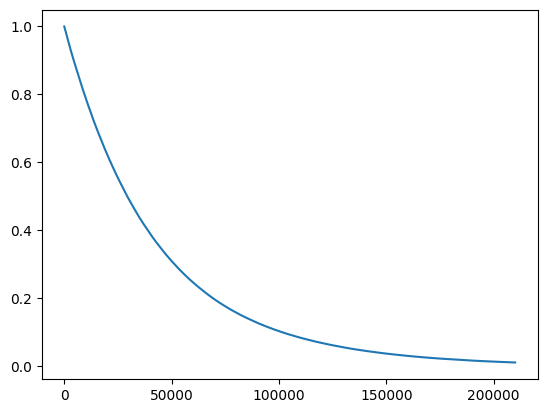

In [ ]:
plt.plot(eps)

In [16]:
import os
# Asegurarse de que el directorio exista, si no existe, créalo
directory = "results/" + name_exp
if not os.path.exists(directory):
    os.makedirs(directory)

exp = {}
exp["R_exp"] = R_exp
exp["Time_exp"] = time_exp
exp["qfun_exp"] = qnet_exp


with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'wb') as f:
    pickle.dump(exp, f)

In [5]:
print("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle")

results/Exp19/Exp_NN_hub3.pickle


In [9]:
with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'rb') as f:
    exp = pickle.load(f)

R_exp = exp["R_exp"]
time_exp = exp["Time_exp"]
qnet_exp = exp["qfun_exp"] 


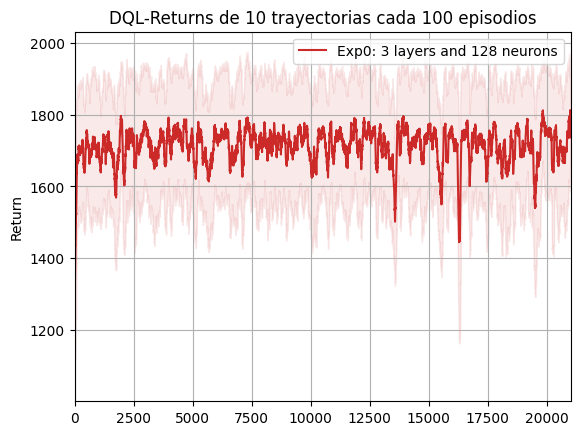

In [6]:
from algorithms.utils import generate_random_colors

num_plots = len(R_exp)  # Número de gráficas
colors = ['#' + ''.join(np.random.choice(list('0123456789ABCDEF'), size=6)) for _ in range(num_plots)]
colors = generate_random_colors(num_plots)

for i, R in enumerate(R_exp):

    Rs = np.array(R).ravel()

    mean = np.array([np.mean(Rs[i:i+100]) for i in range(len(Rs) - 10)])
    std = np.array([np.std(Rs[i:i+100]) for i in range(len(Rs) - 10)])
    time = np.arange(mean.size)
    plt.plot(mean,color=colors[i],label= f"Exp{i}: {len(exp_layers[i])} layers and {exp_layers[i][0]} neurons")
    plt.fill_between(time, mean - std, mean + std, color=colors[i], alpha=0.1)

    plt.xlim(0, len(Rs))
    plt.grid()
    plt.ylabel("Return")
    plt.legend()
    plt.title("DQL-Returns de 10 trayectorias cada 100 episodios")

plt.savefig("results/"+ name_exp +"/Returns_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")

In [23]:
np.mean(Rs[60000:])

69247.665

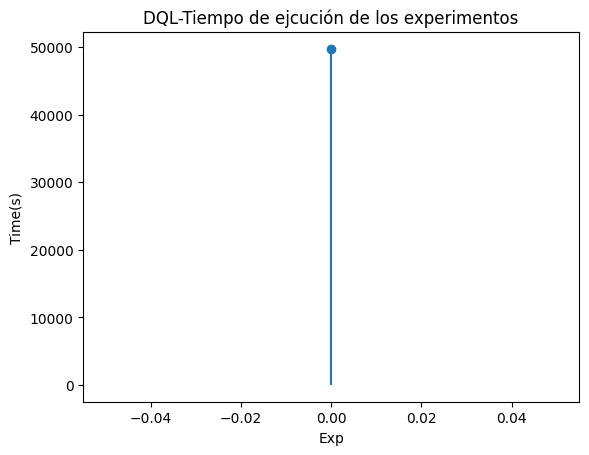

In [11]:
plt.title("DQL-Tiempo de ejcución de los experimentos")
plt.stem(time_exp)
plt.xlabel("Exp")
plt.ylabel("Time(s)")

plt.savefig("results/"+ name_exp +"/Time_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")

In [ ]:
from algorithms.utils import saveGIFT

saveGIFT(env, qnet_exp, "NN","", [0,1], "results/"+ name_exp +"/Qfun_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".gif")

In [8]:
def select_action(net, s, epsilon, nA):
    if np.random.rand() < epsilon:
        return np.random.choice(nA)
    with torch.no_grad():
        return net(torch.tensor(np.array(s),dtype=torch.double)).argmax().item()

In [11]:
env = env_red_toy3(model="Exp", T = 30)
num_sim = 1000
max_steps = env.T

Rs = []
R_t= []
S_sf = []
Num_politicas = 4

for p in range(Num_politicas):
    rs = []
    s_t = []
    r_t = []
    s_sf = []
    for episode in range(num_sim):
        s, _ = env.set_initial(s = [0]*env.I)
        R = 0
        for step in range(max_steps):

            if p == 0:
                a = [1,1,0]
            elif p == 1:
                a = [1,1,1]
            elif p == 2:
                a = list(np.random.choice([0, 1], size=3))
            elif p == 3:
                a = select_action(qnet_exp[0], s, 0, 2**(env.J))
            
            s_prime, r, done, _, _ = env.step(a)
   
            r_t.append(r)
            s_t.append(s)

            R += r

            if done:
                S = s_prime
                break
            s = s_prime    
        rs.append(R)
        s_sf.append(S)
    S_sf.append(s_sf)
    Rs.append(rs)

[28.686, 20.095, 28.423, 28.646]
[1775.2, 1549.1, 1315.8, 1785.4]


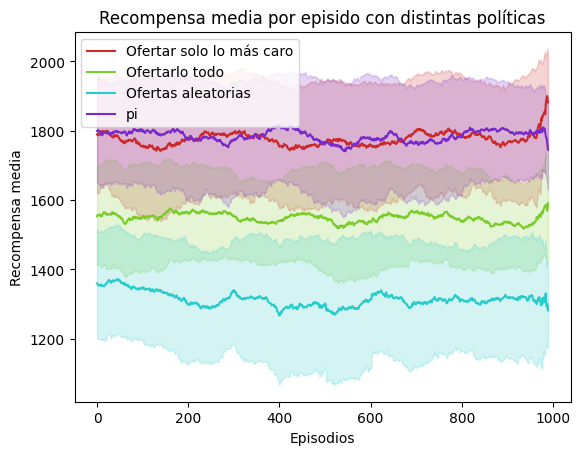

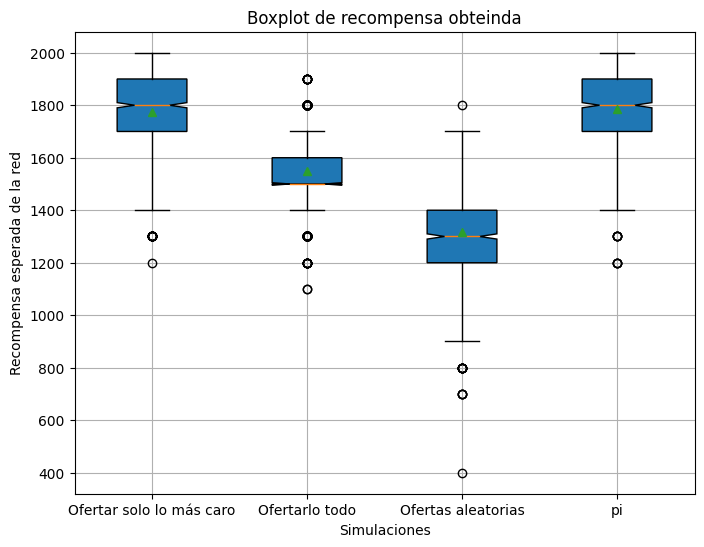

In [12]:
from algorithms.utils import generate_random_colors

colors = generate_random_colors(Num_politicas)
etiqueta =  ["Ofertar solo lo más caro", "Ofertarlo todo", "Ofertas aleatorias","pi"]

for p in range(Num_politicas):
    
    totals = Rs[p]
    x = np.array(totals).ravel()

    mean = np.array([np.mean(x[i:i+100]) for i in range(len(x) - 10)])
    std = np.array([np.std(x[i:i+100]) for i in range(len(x) - 10)])
    time = np.arange(mean.size)
    plt.plot(mean,color=colors[p],label = etiqueta[p])
    #plt.plot(Rsim, color = 'r')
    plt.fill_between(time, mean - std, mean + std, color=colors[p], alpha=0.2)
    plt.title("Recompensa media por episido con distintas políticas")
    plt.xlabel('Episodios')
    plt.ylabel('Recompensa media')
    plt.legend()
    

T_tf_mean = []
for i in range(Num_politicas):
    t_tf = []
    for x in S_sf[i]:
        t_tf.append(x[2])
    T_tf_mean.append(np.mean(t_tf))

print(T_tf_mean)

Rs_f_mean = []
for i in range(Num_politicas):
    Rs_f_mean.append(np.mean(Rs[i]))

print(Rs_f_mean)

datos = Rs
plt.figure(figsize=(8, 6))
plt.boxplot(datos, patch_artist=True, notch=True, showmeans=True)

plt.title('Boxplot de recompensa obteinda')
plt.xlabel('Simulaciones')
plt.ylabel('Recompensa esperada de la red')
plt.xticks(range(1,Num_politicas+1),etiqueta)  # Cambiar etiquetas del eje x
plt.grid(True)
plt.savefig("results/"+ name_exp +"/BoxPlot_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")
plt.show()


In [1]:
np.mean(Rs[3])

NameError: name 'np' is not defined